Advanced Convolutions

**A. Target**
1. change the code such that it uses GPU
2. change the architecture to C1C2C3C40 (basically 3 MPs)
3. total RF must be more than 44
4. one of the layers must use Depthwise Separable Convolution
5. one of the layers must use Dilated Convolution
6. use GAP (compulsory):- add FC after GAP to target #of classes (optional)
7. achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M.

**B. Results**
1. Parameters: 815,200
2. Best Training Accuracy in 20 epochs: 87.72%
3. Best Test Accuracy in 20 epochs: 85.09 %
4. Total RF reached: 76*76 at the end of Conv block 4

**C. Analysis**

Model meets all the mentioned targets. I have used the Depthwise
seprable con and dialted kernel in the conv block 3. Also, As train test gap was coming more in earlier versions, I have used the horizontal flip and random rotations to act as regulaizer and reduce the train test gap. Code is modularized and uploaded as package in git repo. 


In [1]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

In [2]:
!git clone https://github.com/SachinDangayach/test_eva5.git
import sys

Cloning into 'test_eva5'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 25 (delta 9), reused 23 (delta 7), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [3]:
# sys.path
# sys.path.append(r'C:\Users\sdangayach162437\Desktop')

In [4]:
from test_eva5.dataset import session7_dataset as dataset
from test_eva5.models import session8_resnet18_model as models
from test_eva5.models import session8_train_model as train
from test_eva5.models import session8_test_model as test
from test_eva5.utils import session7_utils as utils

## Extract, Load and Transform Data

In [5]:
# Calculate Ture Mean and STD
norm_mean,norm_std = dataset.cifar10_mean_std() #  (0.49, 0.48, 0.45), (0.25, 0.24, 0.26)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Get train and test transform
train_transform, test_transform = dataset.get_transforms(norm_mean,norm_std)

(0.49, 0.48, 0.45) (0.25, 0.24, 0.26)


In [7]:
# Extract and transform the data
train_set,test_set = dataset.get_datasets(train_transform,test_transform)

# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = dataset.get_dataloaders(train_set,test_set)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


### Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 10 images


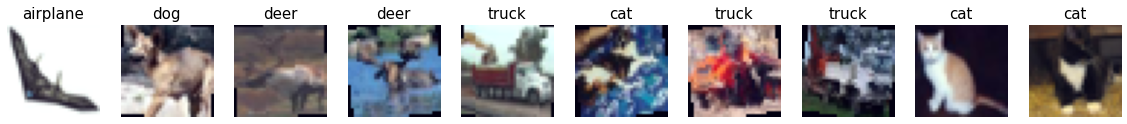

In [8]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

## Import Model and show model summary

In [9]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

## Train and Test Model

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train.train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test.test(model, device, test_loader, test_losses, test_acc)

EPOCH:

  0%|          | 0/391 [00:00<?, ?it/s]

 0


Loss=1.6335862874984741 Batch_id=390 Train Accuracy=36.13: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.4365, Test Accuracy: 4646/10000 (46.46%)

EPOCH: 1


Loss=1.2993402481079102 Batch_id=390 Train Accuracy=53.64: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1001, Test Accuracy: 6061/10000 (60.61%)

EPOCH: 2


Loss=0.7703375816345215 Batch_id=390 Train Accuracy=63.89: 100%|██████████| 391/391 [00:55<00:00,  7.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9341, Test Accuracy: 6681/10000 (66.81%)

EPOCH: 3


Loss=0.7632436156272888 Batch_id=390 Train Accuracy=71.51: 100%|██████████| 391/391 [00:55<00:00,  7.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7977, Test Accuracy: 7218/10000 (72.18%)

EPOCH: 4


Loss=0.6310974955558777 Batch_id=390 Train Accuracy=74.93: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6615, Test Accuracy: 7709/10000 (77.09%)

EPOCH: 5


Loss=0.6597164273262024 Batch_id=390 Train Accuracy=76.74: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7476, Test Accuracy: 7486/10000 (74.86%)

EPOCH: 6


Loss=0.6615154147148132 Batch_id=390 Train Accuracy=77.67: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8058, Test Accuracy: 7360/10000 (73.60%)

EPOCH: 7


Loss=0.8073564767837524 Batch_id=390 Train Accuracy=78.60: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6859, Test Accuracy: 7685/10000 (76.85%)

EPOCH: 8


Loss=0.605912983417511 Batch_id=390 Train Accuracy=79.57: 100%|██████████| 391/391 [00:55<00:00,  7.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7874, Test Accuracy: 7395/10000 (73.95%)

EPOCH: 9


Loss=0.7585862874984741 Batch_id=390 Train Accuracy=80.05: 100%|██████████| 391/391 [00:55<00:00,  7.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8234, Test Accuracy: 7244/10000 (72.44%)

EPOCH: 10


Loss=0.3632826805114746 Batch_id=390 Train Accuracy=87.73: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3760, Test Accuracy: 8717/10000 (87.17%)

EPOCH: 11


Loss=0.34168392419815063 Batch_id=390 Train Accuracy=90.46: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3526, Test Accuracy: 8798/10000 (87.98%)

EPOCH: 12


Loss=0.2865696847438812 Batch_id=390 Train Accuracy=91.95: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3514, Test Accuracy: 8796/10000 (87.96%)

EPOCH: 13


Loss=0.2761593461036682 Batch_id=390 Train Accuracy=92.98: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3513, Test Accuracy: 8827/10000 (88.27%)

EPOCH: 14


Loss=0.07129020988941193 Batch_id=390 Train Accuracy=93.80: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3560, Test Accuracy: 8840/10000 (88.40%)

EPOCH: 15


Loss=0.19024905562400818 Batch_id=390 Train Accuracy=94.42: 100%|██████████| 391/391 [00:55<00:00,  7.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3525, Test Accuracy: 8878/10000 (88.78%)

EPOCH: 16


Loss=0.147216796875 Batch_id=390 Train Accuracy=95.10: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3597, Test Accuracy: 8818/10000 (88.18%)

EPOCH: 17


Loss=0.2258283644914627 Batch_id=390 Train Accuracy=95.43: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3674, Test Accuracy: 8820/10000 (88.20%)

EPOCH: 18


Loss=0.09893840551376343 Batch_id=390 Train Accuracy=95.54: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3720, Test Accuracy: 8867/10000 (88.67%)

EPOCH: 19


Loss=0.2054283171892166 Batch_id=390 Train Accuracy=95.77: 100%|██████████| 391/391 [00:55<00:00,  7.00it/s]



Test set: Average loss: 0.3753, Test Accuracy: 8823/10000 (88.23%)



#  Validation accuracies and Loss change curves

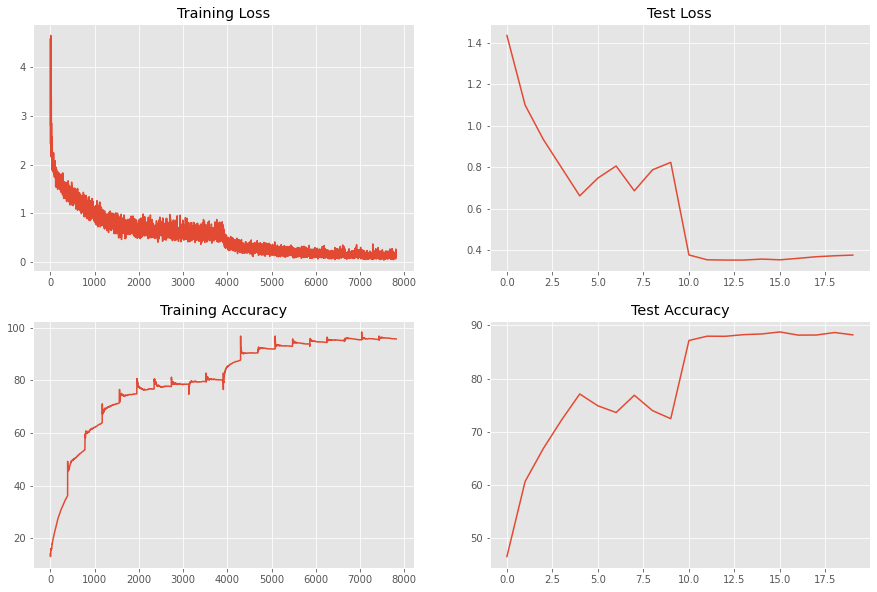

In [11]:
utils.valid_accuracy_loss_plots(train_losses, train_acc, test_losses, test_acc)

## Display misclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

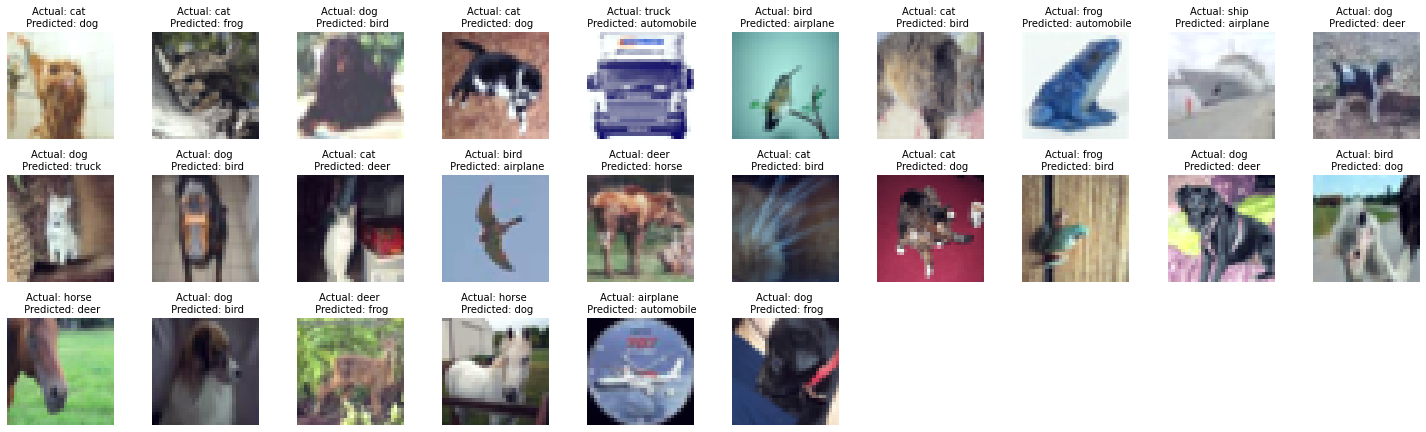

In [12]:
utils.show_misclassified_images(model, classes, test_loader, num_of_images = 25)